In [ ]:
import os
import flopy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from flopy.utils import get_modflow

modflow_path = "../modflow"                  # Directory to MODFLOW executable
modflow_exe_path = modflow_path + "/mf2005"  # Path to the MODFLOW executable
model_input_dir = '../pinal_county_model/'   # Directory of original model files and where model output will be saved
nam_file = 'PM_AWS2019_SS25115.nam'          # Name of the MODFLOW namelist file

# # Get absolute path of model input directory
# print(os.path.abspath(modflow_path))
# print(os.path.abspath(model_input_dir))

# # Ensure MODFLOW executable is available
# if not os.path.exists(modflow_path):
#     os.makedirs(modflow_path)
#     get_modflow(modflow_path)

# Unzip model files if not already unzipped
if os.path.exists(model_input_dir):
    print("Model files already unzipped.")
else:
    print("Unzipping the Model files.")
    ! unzip ../pinal_county_model.zip -d ../

# Load the MODFLOW model using FloPy
print("Loading Pinal County model... (this may take a moment)")

mf = flopy.modflow.Modflow.load(
    f=nam_file,                  # Namelist file <---- Learn this
    exe_name=modflow_exe_path,   # Path to MODFLOW executable
    model_ws=model_input_dir,    # Model workspace (directory)
    check=False                  # Skip detailed checking due to formatting quirks
)

print("Model loaded successfully!")
print(mf)  # Print basic model information


Model files already unzipped.
Loading Pinal County model... (this may take a moment)
Model loaded successfully!
MODFLOW 3 layer(s) 196 row(s) 222 column(s) 194 stress period(s)


In [ ]:
dis = mf.dis      # DIS package
bas = mf.bas6     # BAS6 package
lpf = mf.lpf      # LPF package
wel = mf.wel      # WEL package
riv = mf.riv      # RIV package (if present)
strm = mf.str     # STR package
rch = mf.rch      # RCH package

hk  = lpf.hk.array   # shape (nlay, nrow, ncol) -- hydraulic conductivity
vka = lpf.vka.array  # vertical hydraulic conductivity 
ss  = lpf.ss.array   # specific storage 
sy  = lpf.sy.array   # specific yield

hds_f = f'{model_input_dir}/Pinal.hds'
hds = flopy.utils.HeadFile(hds_f)

grid = mf.modelgrid

In [ ]:
# Print model information
print("Available packages:")
print(mf.get_package_list())
print("="*60)

print(f"\nModel dimensions:")
print(f"  Layers: {mf.nlay}")
print(f"  Rows: {mf.nrow}")
print(f"  Columns: {mf.ncol}")
print(f"  Total cells: {mf.nlay * mf.nrow * mf.ncol}")
print(f"  Stress periods: {mf.nper}")
print("="*60, "\n")

# print stream package information

print("Stream (STR) Package Information:")
print(f"  Number of stream reaches: {strm.nstrm}")
print(f"  Stream reach data for first stress period:\n{strm.stress_period_data[0]}")
print("="*60, "\n")

# print hk, vka, ss, sy array information
print("Hydraulic Conductivity (hk) array shape:", hk.shape)
print("Vertical Hydraulic Conductivity (vka) array shape:", vka.shape)
print("Specific Storage (ss) array shape:", ss.shape)
print("Specific Yield (sy) array shape:", sy.shape)
print("="*60, "\n")



Available packages:
['DIS', 'BAS6', 'LPF', 'WEL', 'MNW2', 'MNWI', 'EVT', 'RCH', 'CHD', 'SWT', 'STR', 'HOB', 'OC', 'GMG']

Model dimensions:
  Layers: 3
  Rows: 196
  Columns: 222
  Total cells: 130536
  Stress periods: 194

Hydraulic Conductivity (hk) array shape: (3, 196, 222)
Vertical Hydraulic Conductivity (vka) array shape: (3, 196, 222)
Specific Storage (ss) array shape: (3, 196, 222)
Specific Yield (sy) array shape: (3, 196, 222)



In [4]:
str


    MODFLOW Stream Package Class.

    Parameters
    ----------
    model : model object
        The model object (of type :class:`flopy.modflow.mf.Modflow`) to which
        this package will be added.
    mxacts : int
        Maximum number of stream reaches that will be in use during any stress
        period. (default is 0)
    nss : int
        Number of stream segments. (default is 0)
    ntrib : int
        The number of stream tributaries that can connect to one segment. The
        program is currently dimensioned so that NTRIB cannot exceed 10.
        (default is 0)
    ndiv : int
        A flag, which when positive, specifies that diversions from segments
        are to be simulated. (default is 0)
    icalc : int
        A flag, which when positive, specifies that stream stages in reaches
        are to be calculated. (default is 0)
    const : float
        Constant value used in calculating stream stage in reaches whenever
        ICALC is greater than 0. This constant

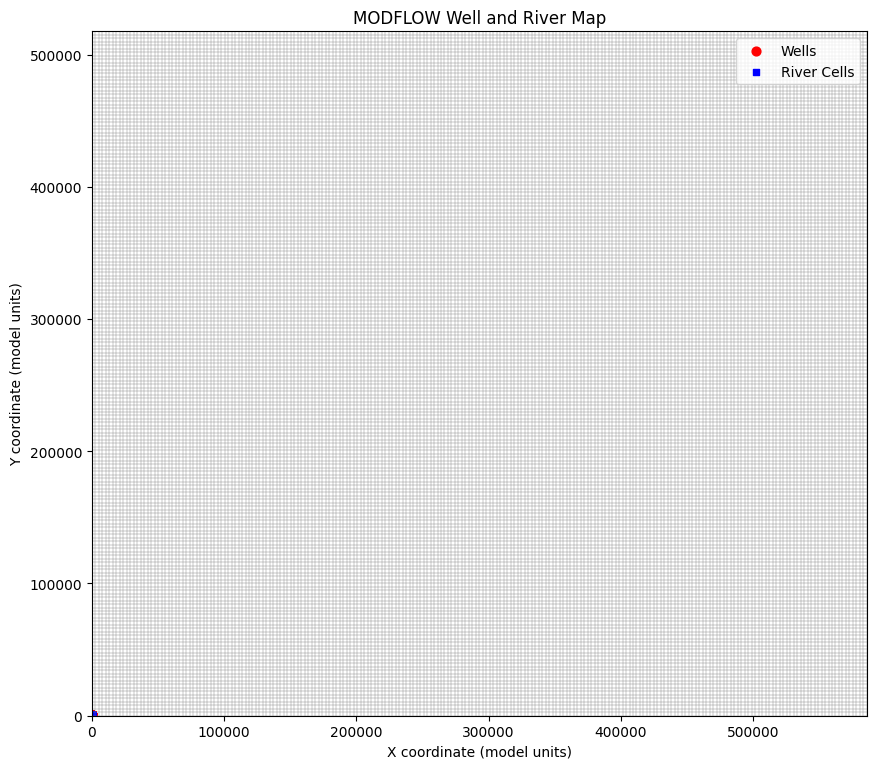

In [ ]:
well_x = []
well_y = []

wel_spd0 = wel.stress_period_data

for rec in wel_spd0:
    print(rec)
    i = rec["i"]
    j = rec["j"]
    well_x.append(i)
    well_y.append(j)


riv_x = []
riv_y = []

str_spd0 = strm.stress_period_data.data[0]

for rec in str_spd0:
    print(rec)
    i = rec["i"]
    j = rec["j"]
    riv_x.append(i)
    riv_y.append(j)


# # --- Plot ---
# fig, ax = plt.subplots(figsize=(10, 10))

# # Plot wells
# ax.scatter(well_x, well_y, s=40, c="red", marker="o", label="Wells")

# # Plot rivers
# ax.scatter(riv_x, riv_y, s=20, c="blue", marker="s", label="River Cells")

# # Plot the model grid
# grid.plot(ax=ax, linewidth=0.3, color="gray")

# ax.set_xlabel("X coordinate (model units)")
# ax.set_ylabel("Y coordinate (model units)")
# ax.set_title("MODFLOW Well and River Map")
# ax.legend()

# plt.show()